In [1]:
from pathlib import Path
import os
cwd_path = Path.cwd(); set_path = str(cwd_path.parent); os.chdir(set_path)

In [2]:
import torch
import matplotlib.pyplot as plt
from FittedModels.utils import plot_distributions
torch.manual_seed(5)
from ImportanceSampling.VanillaImportanceSampler import VanillaImportanceSampling
from TargetDistributions.MoG import MoG
from FittedModels.Models.DiagonalGaussian import DiagonalGaussian
from FittedModels.utils import plot_distributions
from FittedModels.train import LearntDistributionManager
from Utils import plot_func2D, MC_estimate_true_expectation

# Expectation Function

In [3]:
def expectation_function(x):
    A = torch.ones((x.shape[-1], x.shape[-1]))
    return torch.einsum("bi,ij,bj->b", x, A, x)

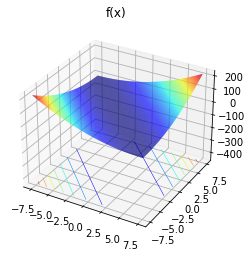

In [4]:
expectation_func_fig = plot_func2D(expectation_function, n_points=200, range=15)

## Key param

In [7]:
epochs = 500
dim = 2
n_samples_estimation = int(1e4)
target = MoG(dim=dim)

## MC Estimate of true expectation

In [8]:
true_expectation = MC_estimate_true_expectation(target, expectation_function, int(1e6))
true_expectation

tensor(18.0070)

# DReG

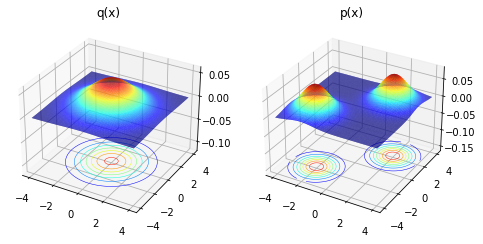

In [9]:
learnt_sampler = DiagonalGaussian(dim=dim)
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="DReG")
fig_before = fig_before_train = plot_distributions(tester)
expectation_before, sampling_weights_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

loss: 4.5559539794921875: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 325.55it/s]


true expectation is 18.007043838500977 
estimate before training is 18.379770278930664 
estimate after training is 18.192338943481445 
effective sample size is 2744.711181640625 
variance in weights is 2.64363588797778e-08


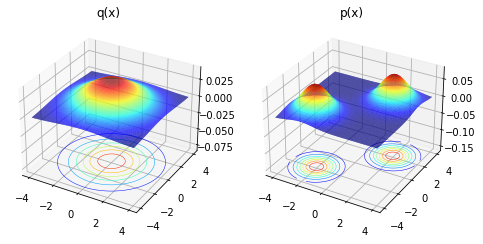

In [10]:
history = tester.train(epochs)
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)

print(f"true expectation is {true_expectation} \n"
      f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size is {info['effective_sample_size']} \n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")
fig_after_train = plot_distributions(tester)

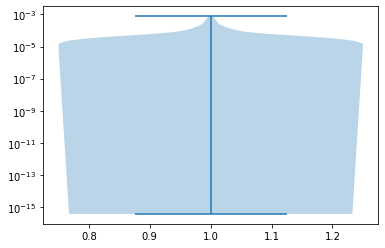

In [11]:
plt.violinplot([info['normalised_sampling_weights']])
plt.yscale("log")

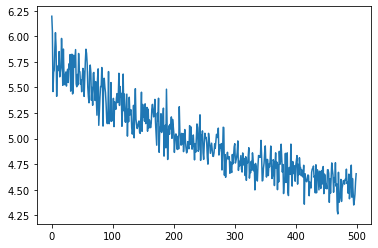

In [12]:
plt.plot(history["loss"])

# KL

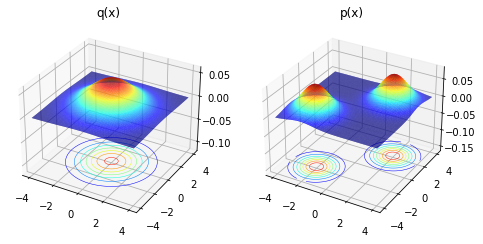

In [13]:
learnt_sampler = DiagonalGaussian(dim=dim)
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="kl")
fig_before = fig_before_train = plot_distributions(tester)
expectation_before, sampling_weights_before = tester.estimate_expectation()

loss: 1.6370600461959839: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 334.06it/s]


true expectation is 18.007043838500977 
estimate before training is 0.0389445498585701 
estimate after training is 0.20743922889232635 
effective sample size is 2151.192138671875 
variance in weights is 3.648949586931849e-08


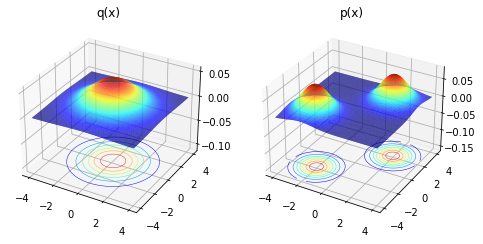

In [14]:
history = tester.train(epochs)
expectation, info = tester.estimate_expectation(n_samples_estimation)
print(f"true expectation is {true_expectation} \n"
      f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n" 
     f"effective sample size is {info['effective_sample_size']} \n"
     f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")
fig_after_train = plot_distributions(tester)

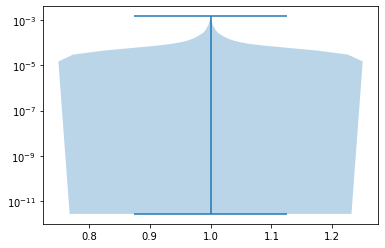

In [15]:
plt.violinplot([info['normalised_sampling_weights']])
plt.yscale("log")

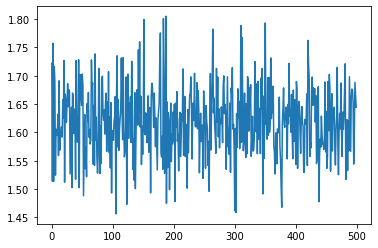

In [16]:
plt.plot(history["loss"])

# Annealed Importance Sampling

In [17]:
from ImportanceSampling.AnnealedImportanceSampler import AnnealedImportanceSampler

In [18]:
annealed_importance_sampler = AnnealedImportanceSampler(tester.learnt_sampling_dist, tester.target_dist)
expectation, info_dict = annealed_importance_sampler.calculate_expectation(n_samples_estimation, expectation_function)

In [19]:
info_dict

{'effective_sample_size': tensor(9828.8623),
 'normalised_sampling_weights': tensor([1.1024e-04, 9.7398e-05, 9.1324e-05,  ..., 7.9562e-05, 9.6795e-05,
         9.4918e-05]),
 'samples': tensor([[ 1.9450,  1.8756],
         [-1.5722, -0.4589],
         [ 1.0775,  0.3820],
         ...,
         [ 3.3546,  2.9622],
         [ 1.0458,  2.4892],
         [-1.6389, -2.3327]])}

In [20]:
expectation

tensor(18.0967)

In [21]:
info_dict['effective_sample_size'] # so close to number of samples!

tensor(9828.8623)

In [22]:
info_dict.keys()

dict_keys(['effective_sample_size', 'normalised_sampling_weights', 'samples'])

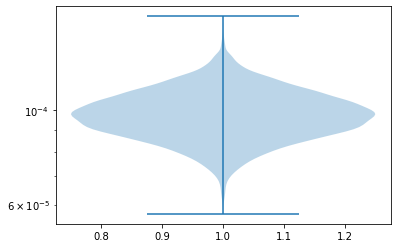

In [23]:
plt.violinplot([info_dict['normalised_sampling_weights']])
plt.yscale("log")

In [25]:
info_dict["samples"].shape

torch.Size([10000, 2])

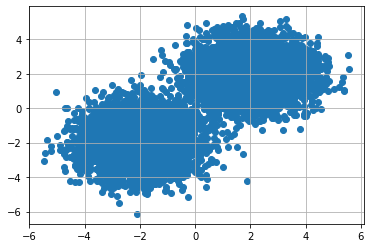

In [27]:
plt.scatter(info_dict["samples"][:, 0], info_dict["samples"][:, 1])
plt.grid()